In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
latent_dim = 100
batch_size = 64 
image_size = 32
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
CIFAR = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
dataloader = DataLoader(CIFAR, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # (3, 32, 32)
            nn.Tanh()  # Normalize to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, img):
        return self.model(img)

In [6]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


In [7]:

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim,1,1).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")



Epoch 0/100 | D Loss: 0.19205541908740997 | G Loss: 1.5990923643112183
Epoch 1/100 | D Loss: 0.32413268089294434 | G Loss: 2.996018171310425
Epoch 2/100 | D Loss: 0.13891778886318207 | G Loss: 2.150007724761963
Epoch 3/100 | D Loss: 0.3109969198703766 | G Loss: 2.2031588554382324
Epoch 4/100 | D Loss: 0.11939959228038788 | G Loss: 3.035346746444702
Epoch 5/100 | D Loss: 0.3925726115703583 | G Loss: 2.8446452617645264
Epoch 6/100 | D Loss: 0.06815344840288162 | G Loss: 4.149097442626953
Epoch 7/100 | D Loss: 0.10048794001340866 | G Loss: 4.298910617828369
Epoch 8/100 | D Loss: 0.20651599764823914 | G Loss: 3.484178066253662
Epoch 9/100 | D Loss: 0.1448049396276474 | G Loss: 2.4735395908355713
Epoch 10/100 | D Loss: 0.19900310039520264 | G Loss: 2.736025333404541
Epoch 11/100 | D Loss: 0.0629417896270752 | G Loss: 3.4442672729492188
Epoch 12/100 | D Loss: 0.14201349020004272 | G Loss: 2.8754189014434814
Epoch 13/100 | D Loss: 0.6544806361198425 | G Loss: 0.7643721103668213
Epoch 14/100 |

In [ ]:
z = torch.randn(16, latent_dim,1,1).to(device)
generated_imgs = generator(z).detach().cpu()

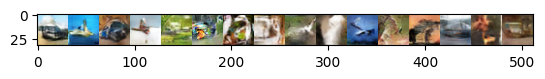

In [12]:
import matplotlib.pyplot as plt
grid_img = torch.cat([img for img in generated_imgs], dim=2).permute(1, 2, 0)
grid_img = (grid_img + 1) / 2  # Denormalize to [0, 1]
plt.imshow(grid_img.numpy())
plt.show()

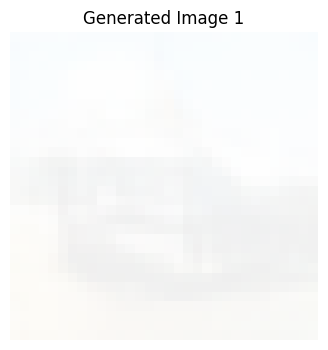

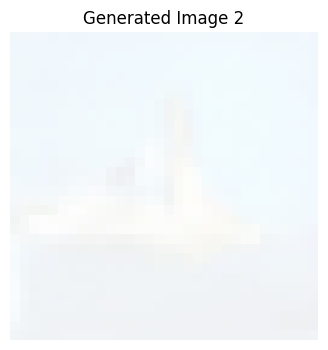

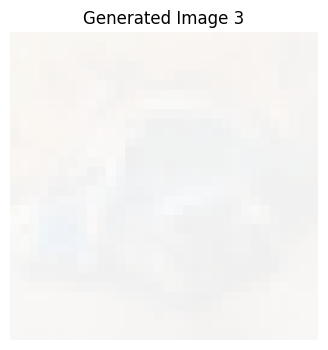

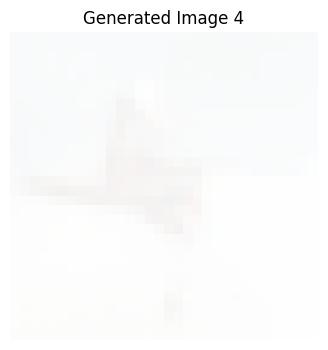

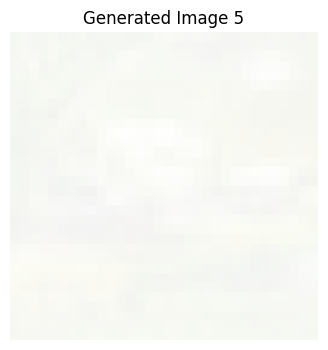

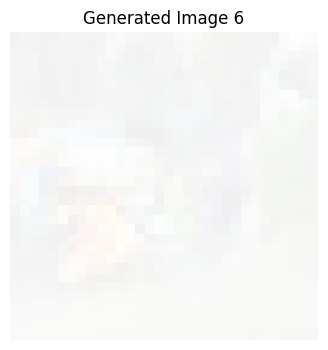

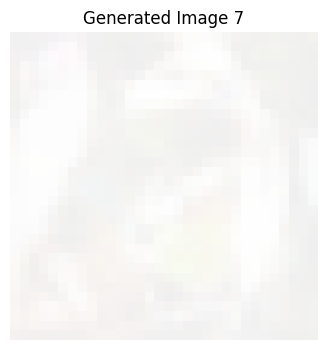

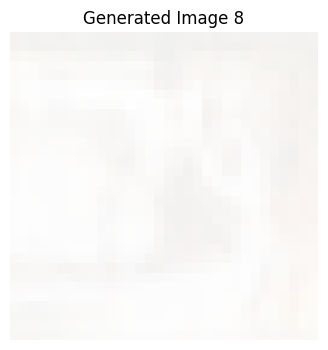

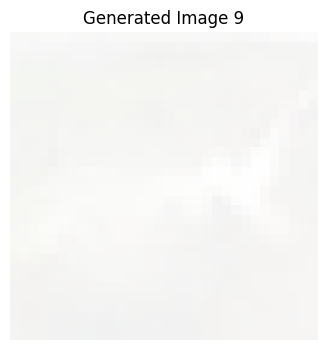

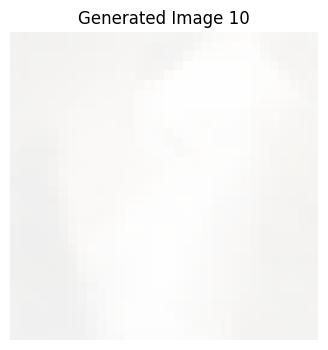

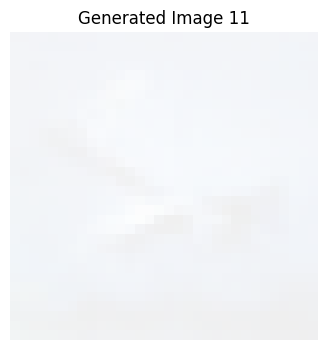

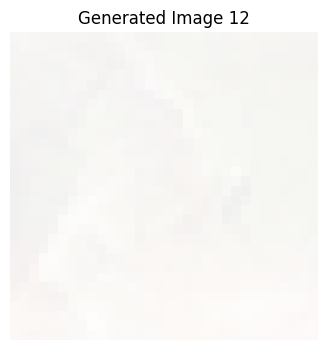

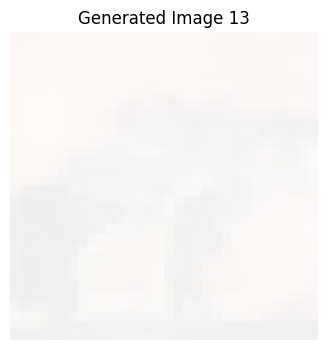

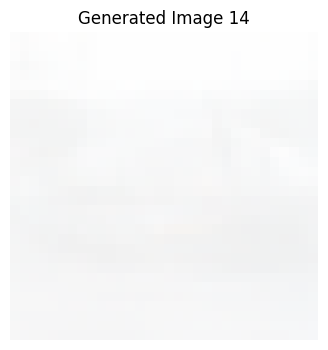

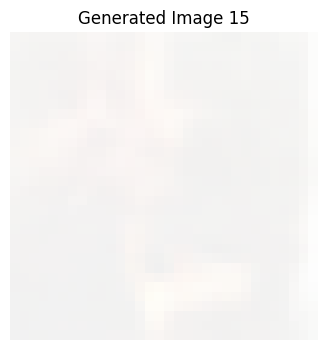

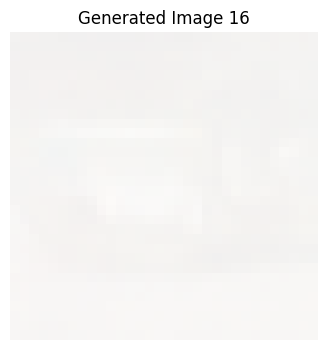

In [ ]:
generated_imgs = (generated_imgs + 1) / 2

# Visualize each image separately
for i in range(16):  # Loop over the 16 generated images
    img = generated_imgs[i].permute(1, 2, 0).numpy()  # Rearrange dimensions to (H, W, C)
    
    plt.figure(figsize=(4,4))  # Set figure size for each image
    plt.imshow(img)  # Show the image
    plt.axis('off')  # Turn off the axes for a cleaner look
    plt.title(f"Generated Image {i + 1}")  # Optional: Add a title
    plt.show()  # Display the image

100%|██████████| 170498071/170498071 [00:58<00:00, 2932799.21it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


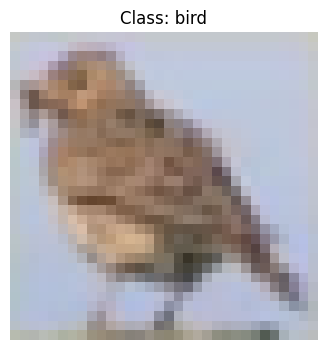

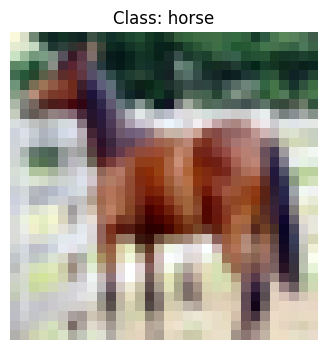

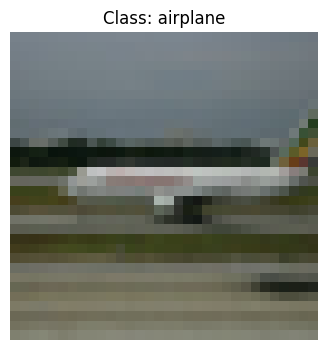

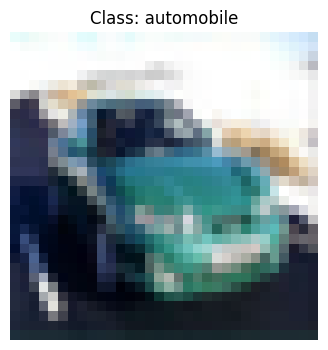

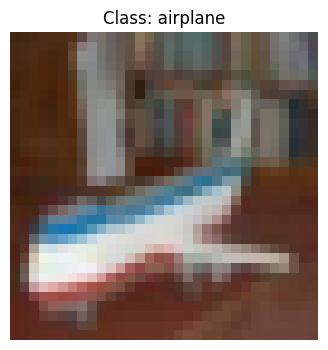

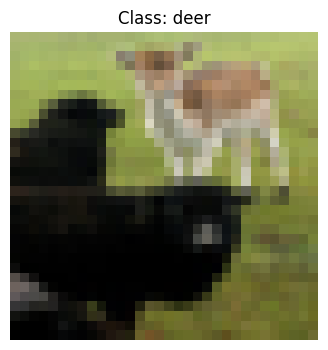

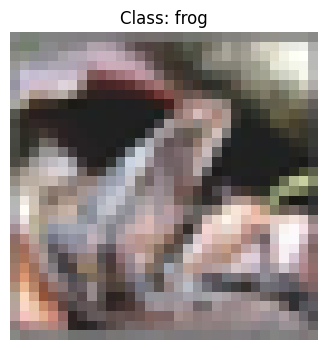

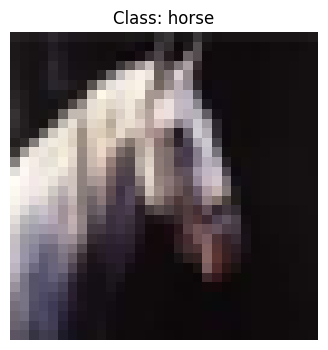

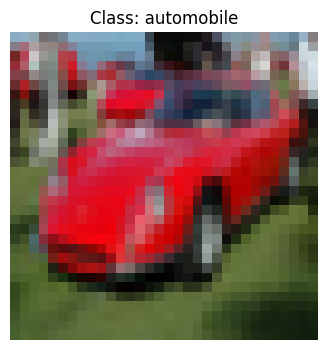

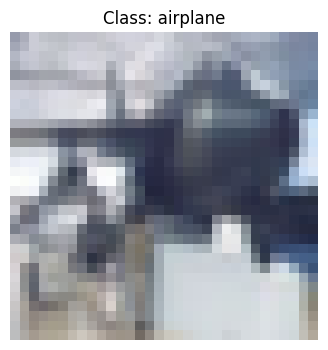

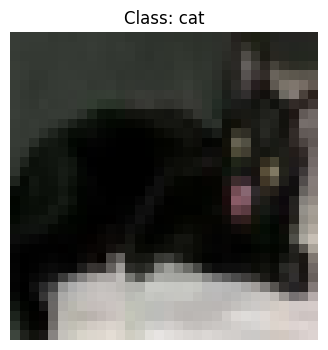

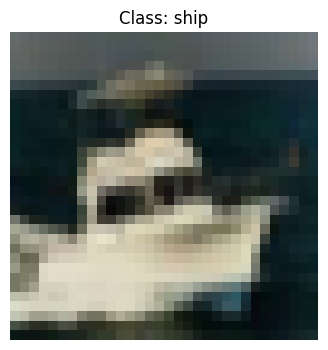

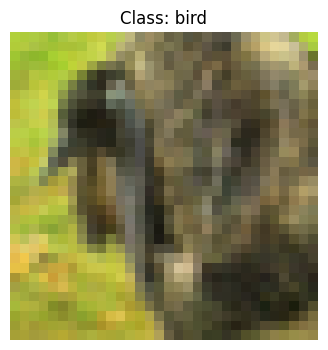

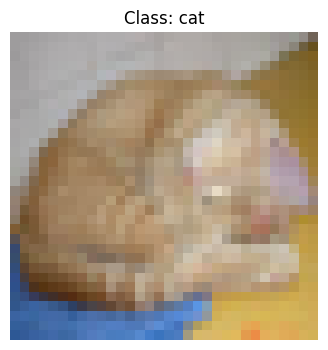

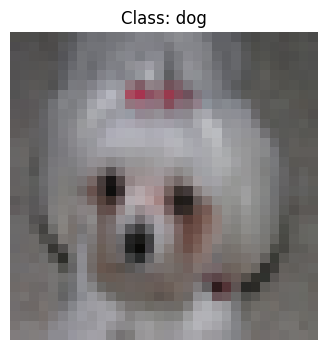

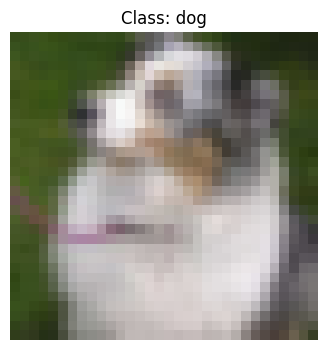

In [18]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader
dataloader = DataLoader(cifar10, batch_size=16, shuffle=True)

# Get a batch of images and labels
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Denormalize images to [0, 1] for proper visualization
images = (images * 0.5) + 0.5  # Undo normalization (from [-1, 1] to [0, 1])

# Classes in CIFAR-10
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Visualize images individually
for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()  # Rearrange dimensions (C, H, W) -> (H, W, C)
    label = labels[i].item()

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {classes[label]}")
    plt.show()
